In [1]:
#Import stuff
import uproot4
import numpy as np
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
import os
import copy

import tensorflow.keras as keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split

import optparse
import importlib
import pathlib

import hist
from hist import Hist

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.ROOT)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5

2023-01-20 14:37:47.664444: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# First make the rate plot for the old NN

#Should multiply the rate by **32MHz**

In [2]:
def score_transform(iso, pt):
    
    PFTAU_NN_OFFSET = 0.1
    PFTAU_NN_SLOPE = 0.2
    PFTAU_NN_OVERALL_SCALE = 1. / 20.1

    PFTAU_NN_LOOSE_CUT = 0.05
    PFTAU_NN_TIGHT_CUT = 0.25

    PFTAU_NN_PT_CUTOFF = 100.0
    
    return iso*(PFTAU_NN_OFFSET + PFTAU_NN_SLOPE*(np.minimum(pt, np.asarray([PFTAU_NN_PT_CUTOFF]))))* PFTAU_NN_OVERALL_SCALE

In [3]:
sig = uproot4.open("../ntuples/Jan_17_2023/test_sig_v8.root")
bkg = uproot4.open("../ntuples/Jan_17_2023/test_bkg_v8.root")

In [5]:
#Calculate the fake rate for old nn
unique_bkg_event = np.unique(np.asarray(bkg['ntuplePupSingle']['tree']['event'].array()))
unique_sig_event = np.unique(np.asarray(sig['ntuplePupSingle']['tree']['event'].array()))

#Sig
pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()
deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()
iso_sig = sig['ntuplePupSingle']['tree']['chargedIso'].array()
selection_sig = (pt_sig > 20) &(abs(deltaR_sig) < 0.4)

sig_id = np.asarray(sig['ntuplePupSingle']['tree']['event'].array()[selection_sig])
sig_pt_selected = np.asarray(pt_sig[selection_sig])
sig_iso_selected = np.asarray(iso_sig[selection_sig])
y_sig = score_transform(sig_iso_selected, sig_pt_selected)

#Bkg
bkg_id = np.asarray(bkg['ntuplePupSingle']['tree']['event'].array())
bkg_pt = np.asarray(bkg['ntuplePupSingle']['tree']['pt'].array()) 
selection_bkg = bkg_pt > 20
bkg_id_pt = bkg_id[selection_bkg]
bkg_pt_selected = bkg_pt[selection_bkg]
bkg_iso_selected = np.asarray(bkg['ntuplePupSingle']['tree']['chargedIso'].array())[selection_bkg]

total_n_minbias = np.unique(bkg_id).shape[0]
total_n_sig = np.intersect1d(np.unique(bkg_id), np.unique(sig_id)).shape[0]

y_bkg = score_transform(bkg_iso_selected, bkg_pt_selected)

In [6]:
tau_score_edges = [round(i,2) for i in np.arange(0, 0.9, 0.01).tolist()]+\
                  [round(i,4) for i in np.arange(0.9, 1, 0.0001)] + [1]

In [7]:
sig_list = []
bkg_list = []

for tau_score_cut in tau_score_edges:
    
    bkg_pass = np.unique(bkg_id_pt[y_bkg.flatten() > tau_score_cut]).shape[0]
    sig_pass = np.unique(sig_id[y_sig.flatten() > tau_score_cut])
    
    real_sig_pass = np.intersect1d(np.unique(bkg_id),sig_pass).shape[0]
    
    sig_list.append(real_sig_pass/total_n_sig)
    bkg_list.append(bkg_pass/total_n_minbias)

In [8]:
bkg_list_scaled = [i*(32e+3) for i in bkg_list]

min(bkg_list_scaled)

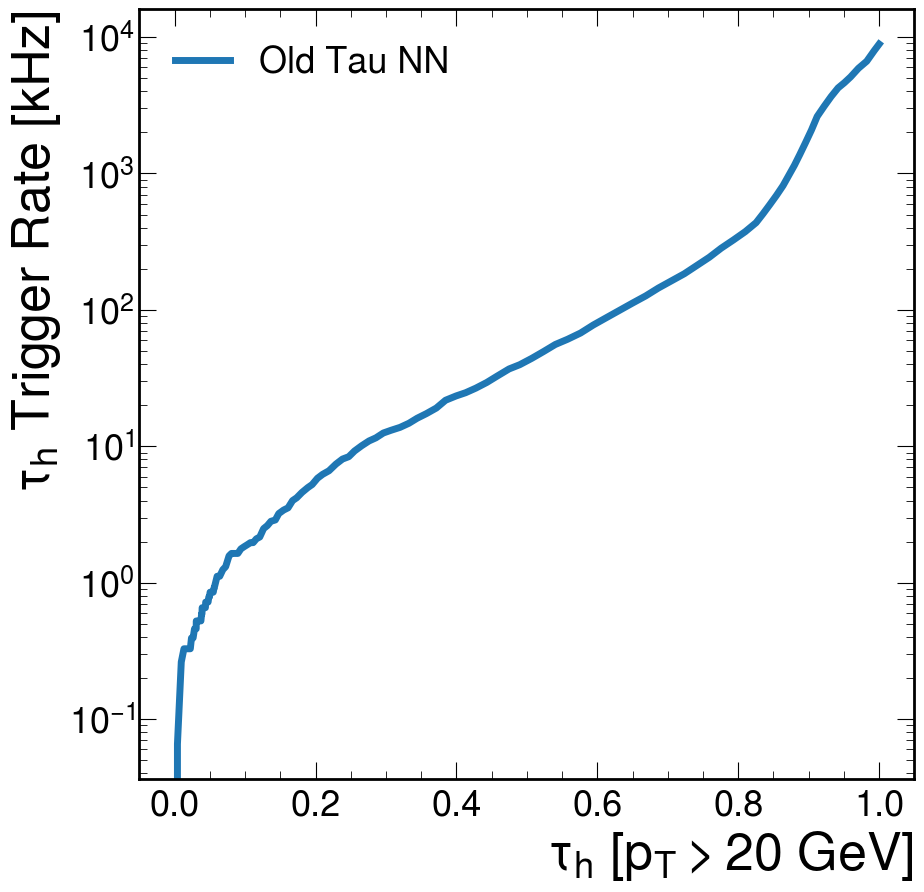

In [9]:
# sig_list_normal = np.load('sig_list_v3.npy')
# bkg_list_normal = np.load('bkg_list_v3.npy')
# bkg_list_normal_scaled = [i*(32e+3) for i in bkg_list_normal]

# plt.plot(sig_list_normal, bkg_list_normal_scaled, label='Retrained Tau NN',linewidth=5)
plt.plot(sig_list, bkg_list_scaled, label='Old Tau NN')
plt.ylabel(r'$\tau_h$ Trigger Rate [kHz]')
plt.xlabel(r'$\tau_h$ [$p_T > 20$ GeV]')
plt.yscale('log')
plt.legend()

In [3]:
unique_bkg_event = np.unique(np.asarray(bkg['ntuplePupSingle']['tree']['event'].array()))
unique_sig_event = np.unique(np.asarray(sig['ntuplePupSingle']['tree']['event'].array()))

#Load model and select out the tau
model = load_model('../models/L1Tau_v3_corrected.h5')

#Sig
sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()

pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()
deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()
selection_sig = (pt_sig > 20) &(abs(deltaR_sig) < 0.4)

sig_id = np.asarray(sig['ntuplePupSingle']['tree']['event'].array()[selection_sig])

X_sig = np.asarray(sig_input[selection_sig])
y_sig = model.predict(X_sig)

#Bkg
bkg_input = np.asarray(bkg['ntuplePupSingle']['tree']['m_inputs'].array())
bkg_id = np.asarray(bkg['ntuplePupSingle']['tree']['event'].array())
bkg_pt = np.asarray(bkg['ntuplePupSingle']['tree']['pt'].array()) 
selection_bkg = bkg_pt > 20
bkg_id_pt = bkg_id[selection_bkg]

total_n_minbias = np.unique(bkg_id).shape[0]
total_n_sig = np.intersect1d(np.unique(bkg_id), np.unique(sig_id)).shape[0]

y_bkg = model.predict(bkg_input[selection_bkg])

2023-01-19 12:13:37.974852: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 12:13:37.980678: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


1179/1179 [==============================] - 8s 7ms/step


In [4]:
tau_score_edges = [round(i,2) for i in np.arange(0, 0.9, 0.01).tolist()]+\
                  [round(i,4) for i in np.arange(0.9, 1, 0.0001)] + [1]

In [5]:
sig_list = []
bkg_list = []

for tau_score_cut in tau_score_edges:
    
    bkg_pass = np.unique(bkg_id_pt[y_bkg.flatten() > tau_score_cut]).shape[0]
    sig_pass = np.unique(sig_id[y_sig.flatten() > tau_score_cut])
    
    real_sig_pass = np.intersect1d(np.unique(bkg_id),sig_pass).shape[0]
    
    sig_list.append(real_sig_pass/total_n_sig)
    bkg_list.append(bkg_pass/total_n_minbias)

In [6]:
bkg_list_scaled = [i*(32e+3) for i in bkg_list]

In [20]:
np.save('sig_list_v3.npy', np.asarray(sig_list))
np.save('bkg_list_v3.npy', np.asarray(bkg_list))

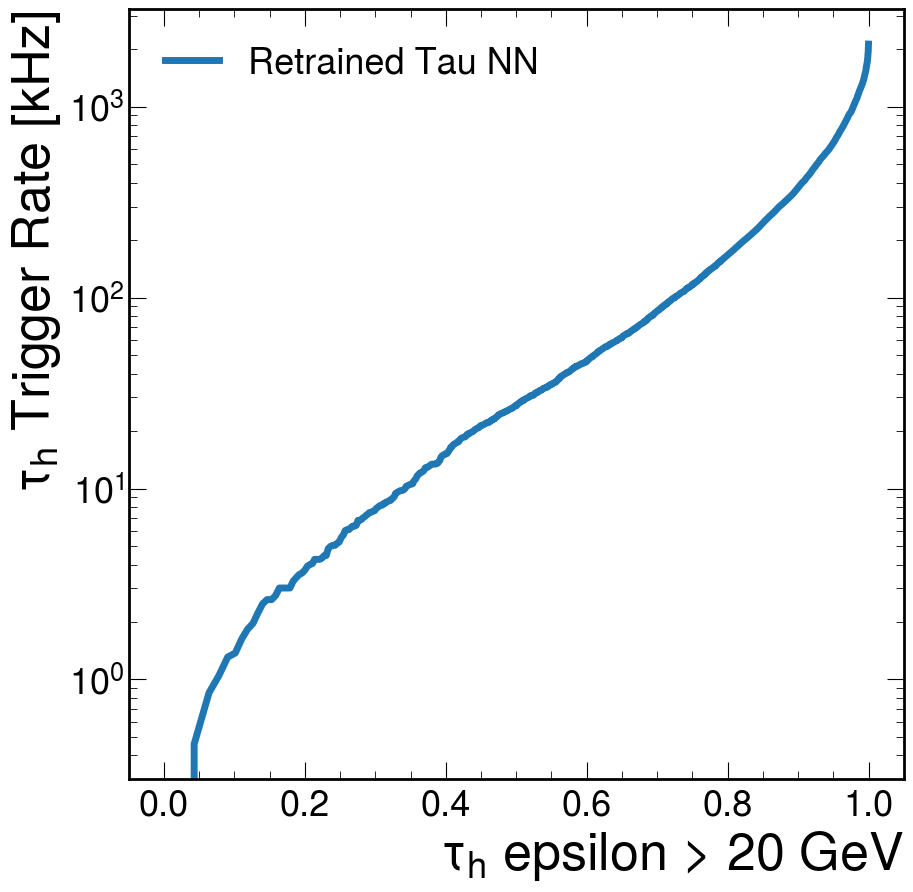

In [15]:
plt.plot(sig_list, bkg_list_scaled, label='Retrained Tau NN')
plt.ylabel(r'$\tau_h$ Trigger Rate [kHz]')
plt.xlabel(r'$\tau_h$ $epsilon$ > 20 GeV')
plt.yscale('log')
plt.legend()

## What about monotonic training?

In [1]:
#Import stuff
import uproot4
import numpy as np
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit?
import os
import copy

import tensorflow.keras as keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split

import optparse
import importlib
import pathlib

import hist
from hist import Hist

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.ROOT)

# import matplotlib.pylab as pylab
# params = {'legend.fontsize': 'medium',
#          'axes.labelsize': 'x-large',
#          'axes.titlesize':'x-large',
#          'xtick.labelsize':'medium',
#          'ytick.labelsize':'medium'}
# pylab.rcParams.update(params)

# #line thickness
# import matplotlib as mpl
# mpl.rcParams['lines.linewidth'] = 5

import torch
from torch.nn.functional import binary_cross_entropy_with_logits
import matplotlib.pyplot as plt

from monotonenorm import direct_norm, SigmaNet, GroupSort


monotonic = True
LIP = 5  # lipschitz constant of the model
EPOCHS = 500

Object `curve_fit` not found.


2023-01-19 17:20:37.443985: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def create_training_data(dir_path):
    
    #Might have to change the version for other ntuple files
    sig = uproot4.open(dir_path+"/test_sig_v8.root")
    bkg = uproot4.open(dir_path+"/test_bkg_v8.root")
    
    sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()
    bkg_input = bkg['ntuplePupSingle']['tree']['m_inputs'].array()
    
    pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()
    deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()
    selection_sig = (pt_sig > 20) & (abs(deltaR_sig) < 0.4)
    
    pt_bkg = bkg['ntuplePupSingle']['tree']['pt'].array()
    deltaR_bkg = bkg['ntuplePupSingle']['tree']['gendr1'].array()
    selection_bkg = pt_bkg > 20
    
    #Maybe better to use 2.4 for eta
    
    #Inputs: pt, eta, phi, particle id(one hot encoded)
    X_sig = np.asarray(sig_input[selection_sig])
    y_sig = np.full(X_sig.shape[0], 1)
    
    X_bkg = np.asarray(bkg_input[selection_bkg])
    y_bkg = np.full(X_bkg.shape[0], 0)
    
    X = np.concatenate([X_sig, X_bkg])
    y = np.concatenate([y_sig, y_bkg])
    
    index = np.arange(X.shape[0])
    
    X_train, X_test, y_train, y_test, index_train, index_test = train_test_split(X, y, index, test_size=0.2, random_state=42)
    
    return torch.from_numpy(X_train), torch.from_numpy(X_test), torch.from_numpy(y_train), torch.from_numpy(y_test), torch.from_numpy(index_train), torch.from_numpy(index_test)

In [3]:
X_train, X_test, y_train, y_test, index_train, index_test = create_training_data("../ntuples/Jan_17_2023")

In [4]:
contraint_index_part = [1] + [0]*7
contraint_index = contraint_index_part*10

In [5]:
def get_model(monotonic):
    def lipschitz_norm(module):
          return direct_norm(
              module,  # the layer to constrain
              "one-inf",  # |W|_1 constraint type
              max_norm=LIP ** (1 / 4),  # norm of the layer (LIP ** (1/nlayers))
              )

    model = torch.nn.Sequential(
      lipschitz_norm(torch.nn.Linear(80, 25)),
      GroupSort(5),
      lipschitz_norm(torch.nn.Linear(25, 10)),
      GroupSort(5),
      lipschitz_norm(torch.nn.Linear(10, 10)),
      GroupSort(5),
      lipschitz_norm(torch.nn.Linear(10, 1)),
    )

    if monotonic:
        model = SigmaNet(
          model,
          sigma=LIP,
          monotone_constraints=contraint_index,
          # 0: don't constrain feature monotonicity,
          # 1: monotonically increasing,
          # -1: monotonically decreasing
          # for each feature individually
        )
        
    return model

In [6]:
model = get_model(monotonic)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [7]:
for i in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = binary_cross_entropy_with_logits(y_pred, y_train.view(-1, 1).float())
    loss.backward()
    optimizer.step()

In [8]:
y_pred = torch.sigmoid(model(X_test))

fpr, tpr, thresholds = roc_curve(y_test, y_pred.detach().numpy())

auc_score = round(auc(fpr, tpr),2)

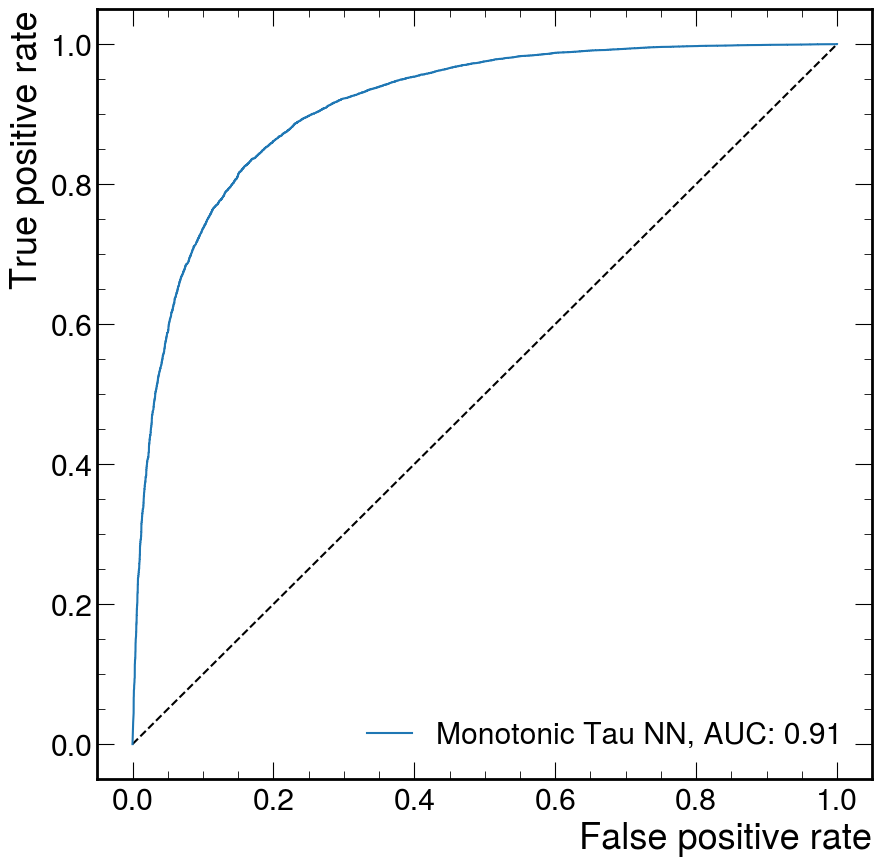

In [26]:
#Create plot for ROC
plt.figure(1)

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label = 'Monotonic Tau NN, AUC: {}'.format(auc_score))

#Establish labels and save image
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')
plt.show()

In [34]:
#Load the test indices
test_index = np.load("../ntuples/Jan_17_2023/index_test.npy")

sig = uproot4.open("../ntuples/Jan_17_2023/test_sig_v8.root")
tau_pt = sig['ntuplePupSingle']['tree']['pt'].array()[test_index]

#Get all the inputs
sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[test_index]

pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()[test_index]
deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[test_index]
selection_sig = (pt_sig > 20) &(abs(deltaR_sig) < 0.4)

#Selected out the tau pt with the basic cuts first
tau_pt_cut = tau_pt[selection_sig]

In [35]:
X_sig = torch.from_numpy(np.asarray(sig_input[selection_sig]))
y_sig = torch.sigmoid(model(X_sig))

In [36]:
nn_cut = y_sig.detach().numpy().flatten() > 0.5

In [37]:
tau_pt_nn = np.asarray(tau_pt_cut)[nn_cut]

#Old nn
old_tau_select = np.asarray(sig['ntuplePupSingle']['tree']['passLoose'].array()[test_index][selection_sig])
tau_pt_old_nn = tau_pt_cut[old_tau_select == 1]

#Fill two plots and divide the two.
pT_egdes = [0,10,15,20,25,30,35,40,45,50,55,60,70,80,100,125,150] #200?
pT_axis = hist.axis.Variable(pT_egdes, name = r"$\tau_h$ $p_T$")

hist_all_tau = Hist(pT_axis)
hist_selected_tau = Hist(pT_axis)
hist_selected_old_tau = Hist(pT_axis)

hist_all_tau.fill(tau_pt_cut)
hist_selected_tau.fill(tau_pt_nn)
hist_selected_old_tau.fill(tau_pt_old_nn)

Hist(Variable([0, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 100, 125, 150], name='$\\tau_h$ $p_T$'), storage=Double()) # Sum: 6174.0 (6350.0 with flow)

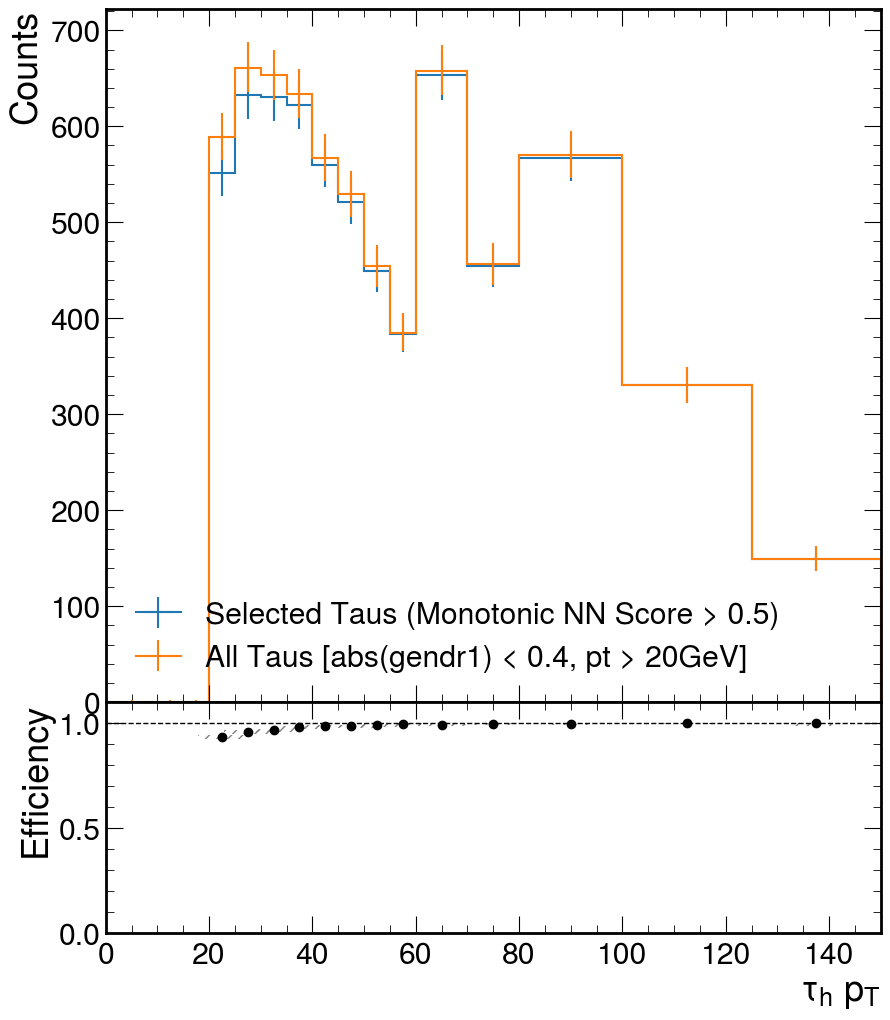

In [38]:
fig = plt.figure(figsize=(10, 12))
main_ax_artists, eff_new_nn_artists = hist_selected_tau.plot_ratio(
    hist_all_tau,
    rp_num_label=r"Selected Taus (Monotonic NN Score > 0.5)",
    rp_denom_label=r"All Taus [abs(gendr1) < 0.4, pt > 20GeV]",
    rp_uncert_draw_type="bar",
    rp_uncertainty_type="efficiency",
)

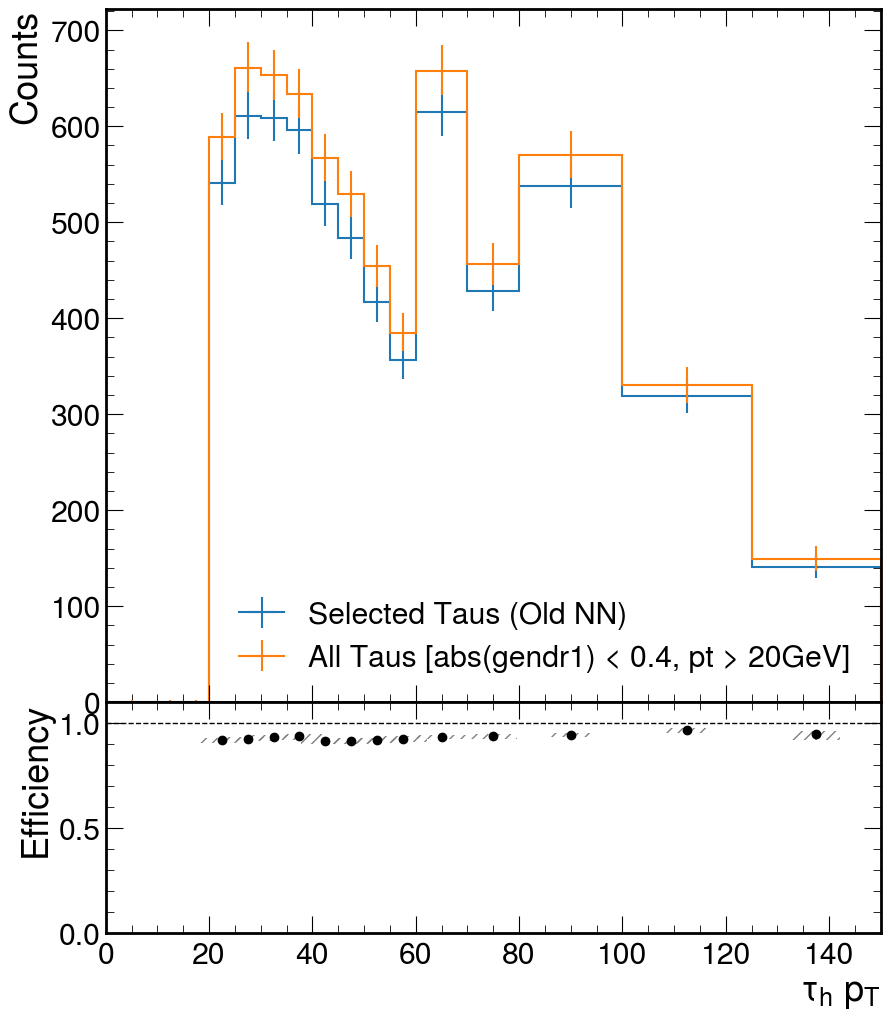

In [39]:
fig = plt.figure(figsize=(10, 12))
main_ax_artists, eff_old_nn_artists = hist_selected_old_tau.plot_ratio(
    hist_all_tau,
    rp_num_label=r"Selected Taus (Old NN)",
    rp_denom_label=r"All Taus [abs(gendr1) < 0.4, pt > 20GeV]",
    rp_uncert_draw_type="bar",
    rp_uncertainty_type="efficiency",
)

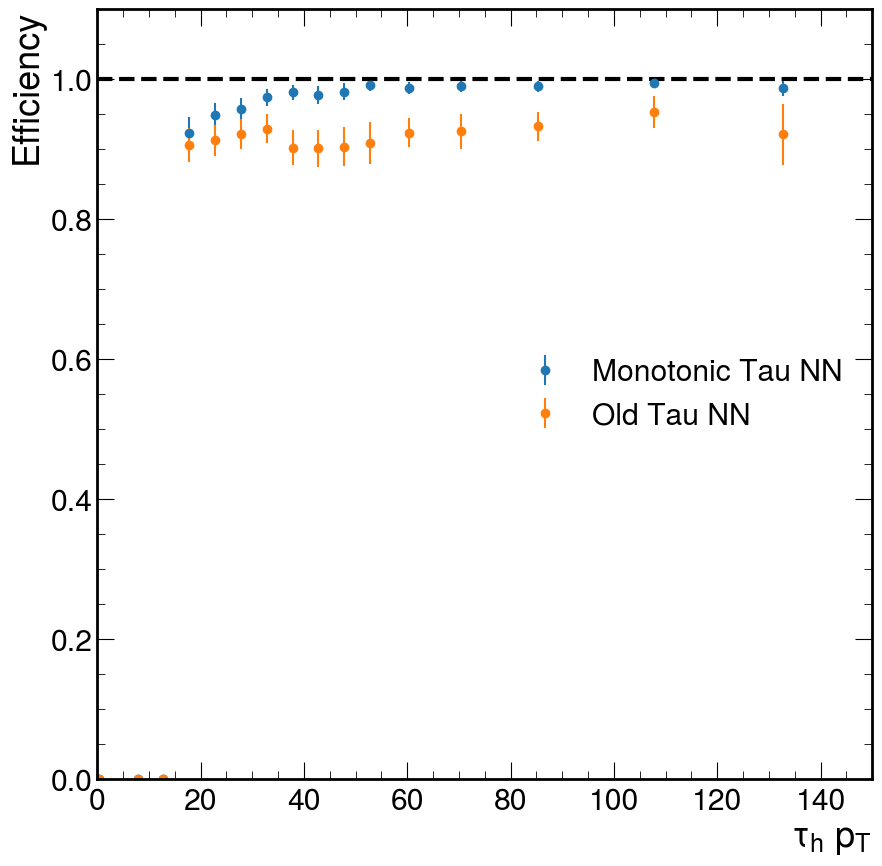

In [40]:
#The real efficiency plot
fig = plt.figure()

eff_new_nn_x = [eff_new_nn_artists.bar.patches[i].get_x() for i in range(len(eff_new_nn_artists.bar.patches))]
eff_new_nn_y = [eff_new_nn_artists.bar.patches[i].get_y() for i in range(len(eff_new_nn_artists.bar.patches))]
eff_new_nn_err = eff_new_nn_artists.bar.datavalues

eff_old_nn_x = [eff_old_nn_artists.bar.patches[i].get_x() for i in range(len(eff_old_nn_artists.bar.patches))]
eff_old_nn_y = [eff_old_nn_artists.bar.patches[i].get_y() for i in range(len(eff_old_nn_artists.bar.patches))]
eff_old_nn_err = eff_old_nn_artists.bar.datavalues

plt.errorbar(eff_new_nn_x, eff_new_nn_y, yerr=eff_new_nn_err, fmt='o', label = 'Monotonic Tau NN')
plt.errorbar(eff_old_nn_x, eff_old_nn_y, yerr=eff_old_nn_err, fmt='o', label = 'Old Tau NN')

plt.hlines(1, 0, 150, linestyles='dashed', color='black', linewidth=3)
plt.ylim([0,1.1])
plt.xlim([0,150])
plt.xlabel(r"$\tau_h$ $p_T$")
plt.ylabel("Efficiency")
plt.legend(loc = 'center right')
plt.show()

In [41]:
tau_eta = sig['ntuplePupSingle']['tree']['eta'].array()[test_index]
tau_eta_cut = tau_eta[selection_sig]
tau_eta_nn = np.asarray(tau_eta_cut)[nn_cut]

#Old nn
old_tau_select = np.asarray(sig['ntuplePupSingle']['tree']['passLoose'].array()[test_index][selection_sig])
tau_eta_old_nn = tau_eta_cut[old_tau_select == 1]

#Fill two plots and divide the two.
eta_egdes = [-2.5,-2.3,-2.0,-1.8,-1.6,-1.4,-1.0,-0.6,-0.2,0.2,0.6,1.0,1.4,1.6,1.8,2.0,2.3,2.5]
eta_axis = hist.axis.Variable(eta_egdes, name = r"$\tau_h$ $\eta$")

hist_all_tau = Hist(eta_axis)
hist_selected_tau = Hist(eta_axis)
hist_selected_old_tau = Hist(eta_axis)

hist_all_tau.fill(tau_eta_cut)
hist_selected_tau.fill(tau_eta_nn)
hist_selected_old_tau.fill(tau_eta_old_nn)

Hist(Variable([-2.5, -2.3, -2, -1.8, -1.6, -1.4, -1, -0.6, -0.2, 0.2, 0.6, 1, 1.4, 1.6, 1.8, 2, 2.3, 2.5], name='$\\tau_h$ $\\eta$'), storage=Double()) # Sum: 6350.0

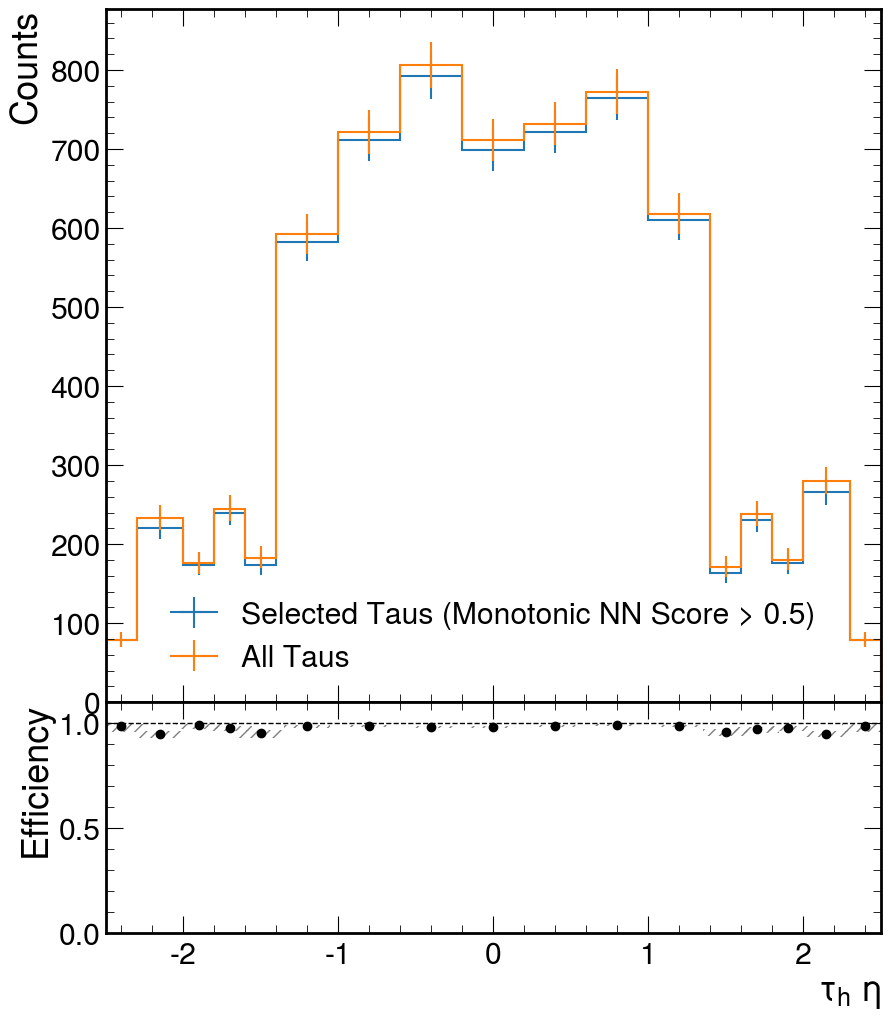

In [42]:
fig = plt.figure(figsize=(10, 12))
main_ax_artists, eff_new_nn_artists = hist_selected_tau.plot_ratio(
    hist_all_tau,
    rp_num_label=r"Selected Taus (Monotonic NN Score > 0.5)",
    rp_denom_label=r"All Taus",
    rp_uncert_draw_type="bar",
    rp_uncertainty_type="efficiency",
)

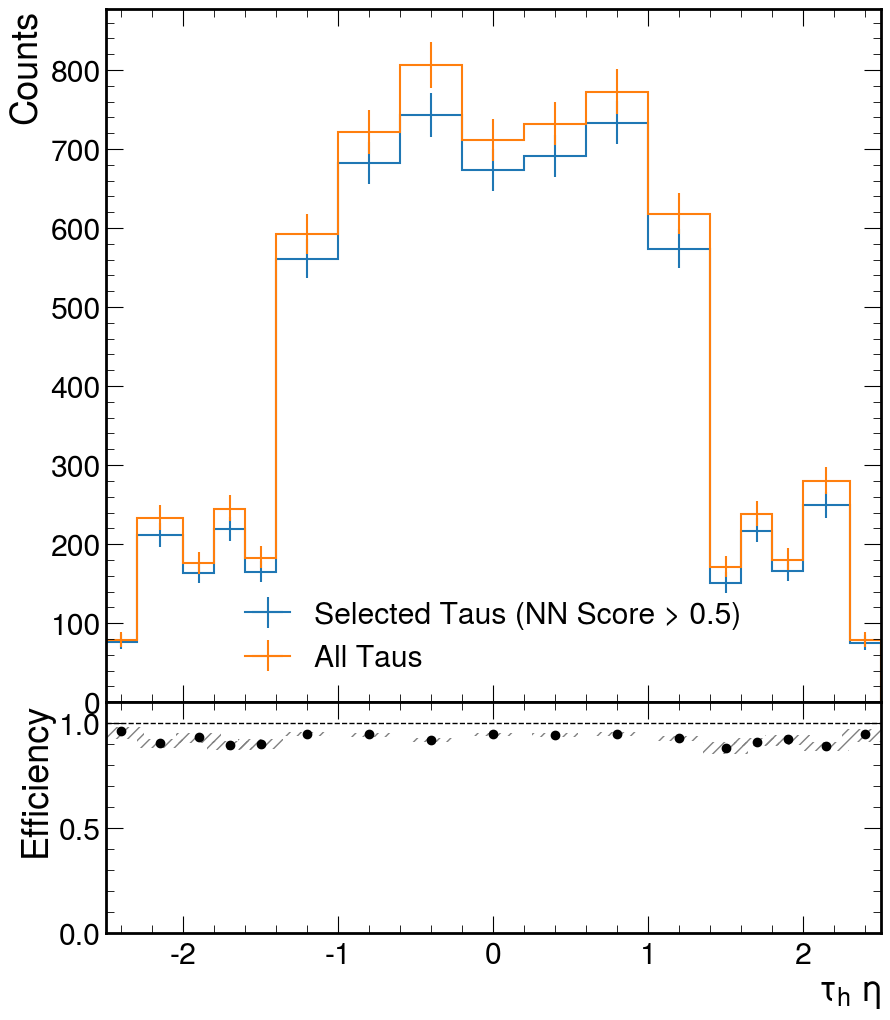

In [43]:
fig = plt.figure(figsize=(10, 12))
main_ax_artists, eff_old_nn_artists = hist_selected_old_tau.plot_ratio(
    hist_all_tau,
    rp_num_label=r"Selected Taus (NN Score > 0.5)",
    rp_denom_label=r"All Taus",
    rp_uncert_draw_type="bar",
    rp_uncertainty_type="efficiency",
)

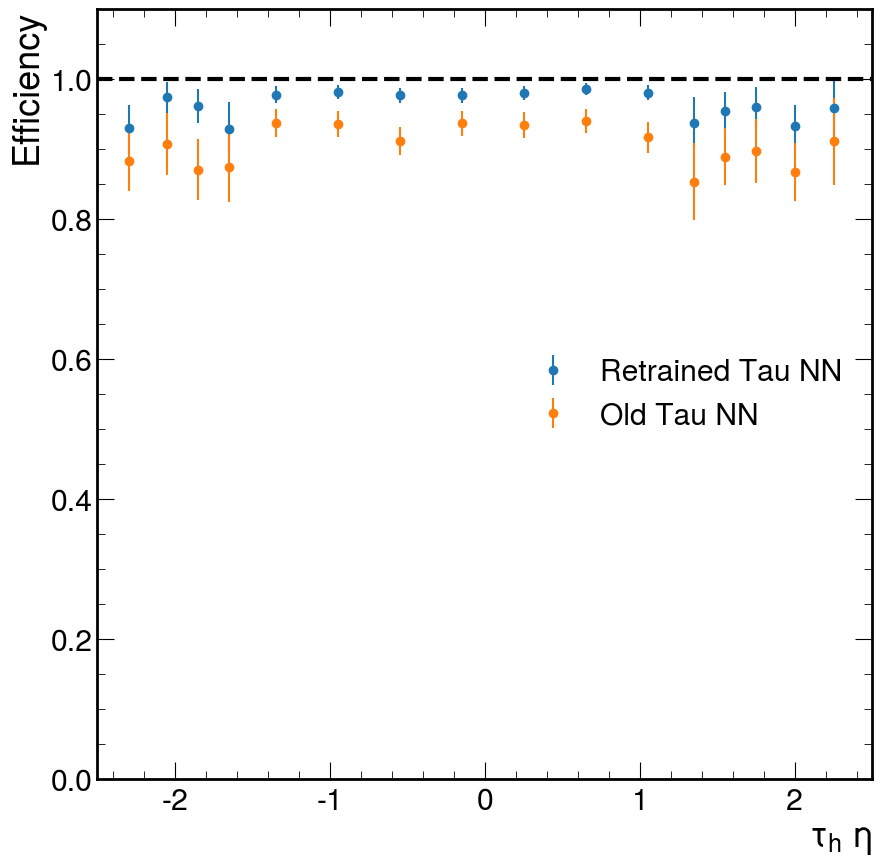

In [20]:
#The real efficiency plot
fig = plt.figure()

eff_new_nn_x = [eff_new_nn_artists.bar.patches[i].get_x() for i in range(len(eff_new_nn_artists.bar.patches))]
eff_new_nn_y = [eff_new_nn_artists.bar.patches[i].get_y() for i in range(len(eff_new_nn_artists.bar.patches))]
eff_new_nn_err = eff_new_nn_artists.bar.datavalues

eff_old_nn_x = [eff_old_nn_artists.bar.patches[i].get_x() for i in range(len(eff_old_nn_artists.bar.patches))]
eff_old_nn_y = [eff_old_nn_artists.bar.patches[i].get_y() for i in range(len(eff_old_nn_artists.bar.patches))]
eff_old_nn_err = eff_old_nn_artists.bar.datavalues

plt.errorbar(eff_new_nn_x, eff_new_nn_y, yerr=eff_new_nn_err, fmt='o', label = 'Retrained Tau NN')
plt.errorbar(eff_old_nn_x, eff_old_nn_y, yerr=eff_old_nn_err, fmt='o', label = 'Old Tau NN')

plt.hlines(1, -2.5, 2.5, linestyles='dashed', color='black', linewidth=3)
plt.ylim([0,1.1])
plt.xlim([-2.5,2.5])
plt.xlabel(r"$\tau_h$ $\eta$")
plt.ylabel("Efficiency")
plt.legend(loc = 'center right')
plt.show()

## Plot the rate for monotonic network

In [44]:
sig = uproot4.open("../ntuples/Jan_17_2023/test_sig_v8.root")
bkg = uproot4.open("../ntuples/Jan_17_2023/test_bkg_v8.root")

unique_bkg_event = np.unique(np.asarray(bkg['ntuplePupSingle']['tree']['event'].array()))
unique_sig_event = np.unique(np.asarray(sig['ntuplePupSingle']['tree']['event'].array()))

#Sig
sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()

pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()
deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()
selection_sig = (pt_sig > 20) &(abs(deltaR_sig) < 0.4)

sig_id = np.asarray(sig['ntuplePupSingle']['tree']['event'].array()[selection_sig])

X_sig = torch.from_numpy(np.asarray(sig_input[selection_sig]))
y_sig = torch.sigmoid(model(X_sig))

#Bkg
bkg_input = np.asarray(bkg['ntuplePupSingle']['tree']['m_inputs'].array())
bkg_id = np.asarray(bkg['ntuplePupSingle']['tree']['event'].array())
bkg_pt = np.asarray(bkg['ntuplePupSingle']['tree']['pt'].array()) 
selection_bkg = bkg_pt > 20
bkg_id_pt = bkg_id[selection_bkg]

total_n_minbias = np.unique(bkg_id).shape[0]
total_n_sig = np.intersect1d(np.unique(bkg_id), np.unique(sig_id)).shape[0]

y_bkg = torch.sigmoid(model(torch.from_numpy(bkg_input[selection_bkg])))

In [45]:
tau_score_edges = [round(i,2) for i in np.arange(0, 0.9, 0.01).tolist()]+\
                  [round(i,4) for i in np.arange(0.99, 1, 0.0001)] + [1]

In [46]:
sig_list = []
bkg_list = []

for tau_score_cut in tau_score_edges:
    
    bkg_pass = np.unique(bkg_id_pt[y_bkg.flatten() > tau_score_cut]).shape[0]
    sig_pass = np.unique(sig_id[y_sig.flatten() > tau_score_cut])
    
    real_sig_pass = np.intersect1d(np.unique(bkg_id),sig_pass).shape[0]
    
    sig_list.append(real_sig_pass/total_n_sig)
    bkg_list.append(bkg_pass/total_n_minbias)

In [47]:
bkg_list_scaled = [i*(32e+3) for i in bkg_list]

In [49]:
!ls 

Eff_plots_Jan_17_2023.ipynb	    Tau_retrain_Jan_12_2023_mass.ipynb
Eff_plots_Jan_17_2023_mass.ipynb    Tau_retrain_Jan_17_2023.ipynb
Eff_plots_Jan_19_2023_EmSeed.ipynb  Tau_retrain_Jan_17_2023_mass.ipynb
MonoTau_Jan_19_2023.ipynb	    Tau_retrain_Jan_19_2023_EMSeed.ipynb
MonoTau_Jan_19_2023_v2.ipynb	    bkg_list_v3.npy
MonoTau_Jan_19_2023_v3.ipynb	    btag_test_1.ipynb
Rate_plots_Jan_17_2023.ipynb	    sig_list_v3.npy
Tau_retrain_Jan_12_2023.ipynb


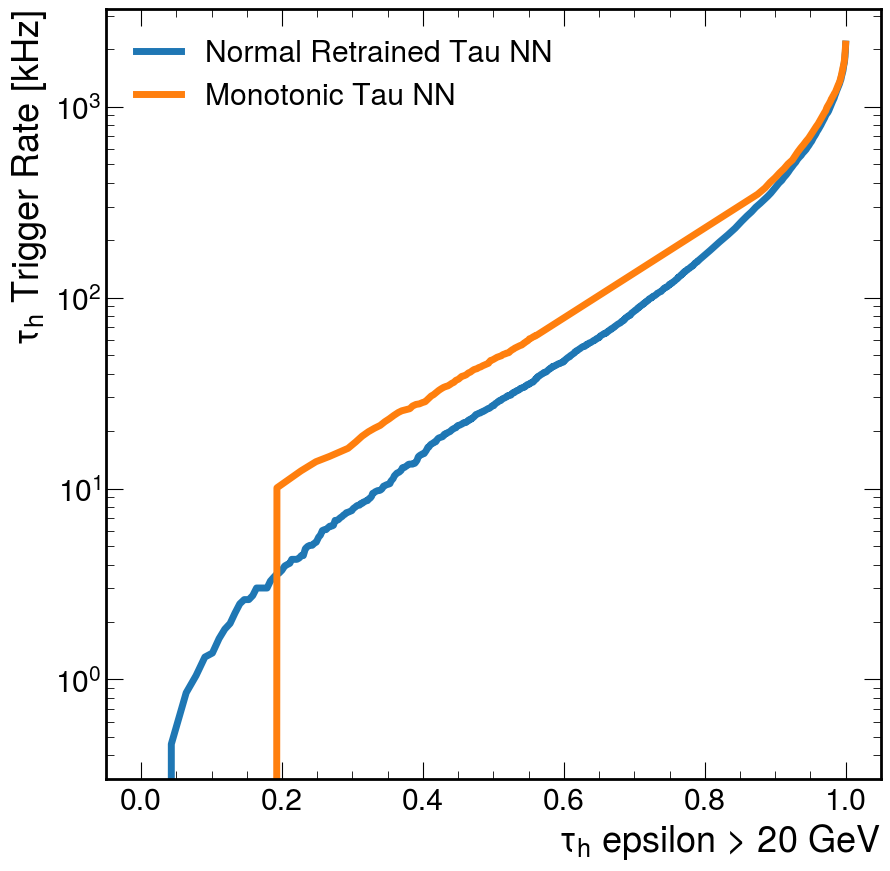

In [52]:
sig_list_normal = np.load('sig_list_v3.npy')
bkg_list_normal = np.load('bkg_list_v3.npy')
bkg_list_normal_scaled = [i*(32e+3) for i in bkg_list_normal]

plt.plot(sig_list_normal, bkg_list_normal_scaled, label='Normal Retrained Tau NN',linewidth=5)
plt.plot(sig_list, bkg_list_scaled, label='Monotonic Tau NN',linewidth=5)
plt.ylabel(r'$\tau_h$ Trigger Rate [kHz]')
plt.xlabel(r'$\tau_h$ $epsilon$ > 20 GeV')
plt.yscale('log')
plt.legend()